In [1]:
# Imports
import numpy as np
import pandas as pd
import scipy as scp
import pickle 
import os
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [ ]:
# Support function
def bin_arbitrary_fptd(out = [0, 0],
                       bin_dt = 0.04,
                       nbins = 256,
                       nchoices = 2,
                       choice_codes = [-1.0, 1.0],
                       max_t = 10.0): # ['v', 'a', 'w', 'ndt', 'angle']

    # Generate bins
    if nbins == 0:
        nbins = int(max_t / bin_dt)
        bins = np.zeros(nbins + 1)
        bins[:nbins] = np.linspace(0, max_t, nbins)
        bins[nbins] = np.inf
    else:    
        bins = np.zeros(nbins + 1)
        bins[:nbins] = np.linspace(0, max_t, nbins)
        bins[nbins] = np.inf

    cnt = 0
    counts = np.zeros( (nbins, nchoices) ) 

    for choice in choice_codes:
        counts[:, cnt] = np.histogram(out[:, 0][out[:, 1] == choice], bins = bins)[0] 
        #print(np.histogram(out[:, 0][out[:, 1] == choice], bins = bins)[1])
        cnt += 1
    return counts

In [17]:
tt = pd.read_csv('/media/data_cifs/afengler/data/real/chong/chongdata.csv')

In [209]:
# Process original dataframe

# reorder the columns for readability
tt_2 = tt[['subj', 'blockN', 'rxtime',
           'response', 'correct', 'isHighCorrect', 
           'isLowCorrect', 'highDim', 'lowDim', 'irrDim', 
           'highDimCoh', 'lowDimCoh', 'irrDimCoh', 
           'lineCoh', 'colorPer', 'anglePer', 'lineOption', 'colorOption', 'angleOption']]


# recode the stimulus dimension option level from 1,2 to 0,1
tt_2['lineOption'] = tt_2['lineOption'] - 1
tt_2['colorOption'] = tt_2['colorOption'] - 1
tt_2['angleOption'] = (tt_2['anglePer'] > 0.5) * 1

In [237]:
# Add a bunch of columns concerning response coding (previously unusable for me)

N = tt_2.shape[0]

tt_2['cr_af'] = 0 # correct response --> constently coded deriving from stimulus properties
tt_2['sr_af'] = 0 # synthetic response --> coded taking into account stimulus properties and subject being wrong on high / low dim
tt_2['sar_af'] = 0 # synthetic accuracy coded response (0: high wrong, low wrong 1: high wrong, low right, 2: high right, low wrong, 3: high right, low right)

for i in range(N):
    # highdim
    h = tt_2.iloc[i, 7]

    # lowdim
    l = tt_2.iloc[i, 8]

    # code 'correct response'
    tt_2.loc[i, ['cr_af']] = tt_2.iloc[i, 15 + l] + (tt_2.iloc[i, 15 + h] * 2)
    
    # code synthetic (subject-) response
    tt_2.loc[i, ['sr_af']] = int((tt_2.iloc[i, 15 + l] + (1 - tt_2.iloc[i, 6])) % 2) + int((tt_2.iloc[i, 15 + h] + (1 - tt_2.iloc[i, 5])) % 2) * 2 
    
    # code synthetic accuracy coded response
    tt_2.loc[i, ['sar_af']] = tt_2.iloc[i, 6] + (tt_2.iloc[i, 5] * 2) 

    if (i % 1000) == 0:
        print(i)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000


In [267]:
# save my new dataframe
pickle.dump(tt_2, open('/media/data_cifs/afengler/data/real/chong/chong_preprocessed_af.pickle', 'wb'))

In [266]:
# Prep data for mlp (split by stimulus coherence)

tt_ll = tt_2.loc[(tt_2['highDimCoh'].values == 1) * (tt_2['lowDimCoh'].values == 1)][['rxtime', 'sar_af']].values
tt_hh = tt_2.loc[(tt_2['highDimCoh'].values == 2) * (tt_2['lowDimCoh'].values == 2)][['rxtime', 'sar_af']].values
tt_lh = tt_2.loc[(tt_2['highDimCoh'].values == 1) * (tt_2['lowDimCoh'].values == 2)][['rxtime', 'sar_af']].values
tt_hl = tt_2.loc[(tt_2['highDimCoh'].values == 2) * (tt_2['lowDimCoh'].values == 1)][['rxtime', 'sar_af']].values


tt_mlp_coh_dict = {0: tt_ll, 1: tt_lh, 2: tt_hl, 3: tt_hh}

tt_base_mlp = tt_2
tt_info_pd = pd.DataFrame(data = {'highCoh': [0, 0, 1, 1], 'lowCoh': [0, 1, 0, 1]})

tt_full_mlp_coh = [tt_base_mlp, tt_cnn_coh, tt_info_pd]
pickle.dump(tt_full_mlp_coh, open('/media/data_cifs/afengler/data/real/chong/chong_full_mlp_coh.pickle', 'wb'))

In [268]:
# Prep data for cnn (split by stimulus coherence)

tt_ll = tt_2.loc[(tt_2['highDimCoh'].values == 1) * (tt_2['lowDimCoh'].values == 1)][['rxtime', 'sar_af']].values
tt_hh = tt_2.loc[(tt_2['highDimCoh'].values == 2) * (tt_2['lowDimCoh'].values == 2)][['rxtime', 'sar_af']].values
tt_lh = tt_2.loc[(tt_2['highDimCoh'].values == 1) * (tt_2['lowDimCoh'].values == 2)][['rxtime', 'sar_af']].values
tt_hl = tt_2.loc[(tt_2['highDimCoh'].values == 2) * (tt_2['lowDimCoh'].values == 1)][['rxtime', 'sar_af']].values

tt_ll_binned = bin_arbitrary_fptd(out = tt_ll,
                                  nbins = 512,
                                  nchoices = 4,
                                  choice_codes = [0, 1, 2, 3],
                                  max_t = 20)
tt_hh_binned = bin_arbitrary_fptd(out = tt_hh,
                                  nbins = 512,
                                  nchoices = 4,
                                  choice_codes = [0, 1, 2, 3],
                                  max_t = 20)
tt_lh_binned = bin_arbitrary_fptd(out = tt_lh,
                                  nbins = 512,
                                  nchoices = 4,
                                  choice_codes = [0, 1, 2, 3],
                                  max_t = 20)
tt_hl_binned = bin_arbitrary_fptd(out = tt_hl,
                                  nbins = 512,
                                  nchoices = 4,
                                  choice_codes = [0, 1, 2, 3],
                                  max_t = 20)

tt_cnn_coh = np.zeros((4, 512, 4))

tt_cnn_coh[0, :, :] = tt_ll_binned
tt_cnn_coh[1, :, :] = tt_lh_binned
tt_cnn_coh[2, :, :] = tt_hl_binned
tt_cnn_coh[3, :, :] = tt_hh_binned


tt_base_cnn = tt_2
tt_info_pd = pd.DataFrame(data = {'highCoh': [0, 0, 1, 1], 'lowCoh': [0, 1, 0, 1]})

tt_full_cnn_coh = [tt_base_cnn, tt_cnn_coh, tt_info_pd]
pickle.dump(tt_full_cnn_coh, open('/media/data_cifs/afengler/data/real/chong/chong_full_cnn_coh.pickle', 'wb'), protocol = 2)

In [270]:
# Test loading of data
mlp_test = pickle.load(open('/media/data_cifs/afengler/data/real/chong/chong_full_mlp_coh.pickle', 'rb'))
cnn_test = pickle.load(open('/media/data_cifs/afengler/data/real/chong/chong_full_cnn_coh.pickle', 'rb'), encoding = 'latin1')

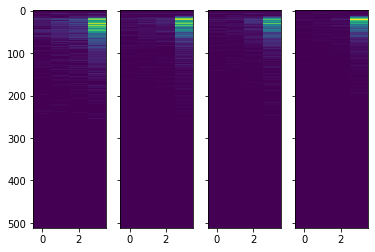

In [277]:
# Graph illustrating (rt, choice) behavior across conditions
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey = True)
ax1.imshow(cnn_test[1][0,:,:], aspect = 'auto')
ax2.imshow(cnn_test[1][1,:,:], aspect = 'auto')
ax3.imshow(cnn_test[1][2,:,:], aspect = 'auto')
ax4.imshow(cnn_test[1][3,:,:], aspect = 'auto')

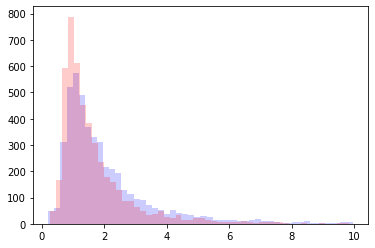

In [48]:
# some basic plots (not used)
color = ['blue', 'red', 'green']
for i in [1,2]:
    plt.hist(tt.loc[(tt['lowDimCoh'] == i) & (tt['highDimCoh'] == 2) & ]['rxtime'], bins = 50, alpha = 0.2, color = color[i - 1])

In [ ]:
# some basic stats (not used)
for i in [1, 2]:
    for j in [1, 2]:
        print(tt.loc[(tt['lowDimCoh'] == i) & (tt['highDimCoh'] == j) & (tt['subj'] == 3)]['rxtime'].mean())